## Naive Wavenet Model
#### reference : WaveNet: A Generative Model for Raw Audio, arxiv.1609.03499
<img src="wavenet1.png" width=700>
<img src="wavenet2.png" width=700>


In [5]:
import numpy as np

# librosa 라이브러리, wav, mp3등 오디오 파일을 numpy array로 불러오는데 필요. 내장 디코더는 없고, ffmpeg backend를 사용함.
import librosa

# librosa에서 spectrogram 등을 보여주는데 사용되는 모듈
import librosa.display

# librosa display는 matplotlib를 이용하는데 이를 같이 import해서 보여주는데 있어 세부적인 사항들을 조정할 수 있음.
import matplotlib.pyplot as plt


## wav 파일 목록 얻기

In [6]:
import os
from os import listdir
from os.path import isfile, join

data_dir = '/home/scpark/hard/datasets/LJSpeech-1.1/wavs'

# 해당 디렉토리에 있는 파일 중 이름에 wav가 들어가 있는 모든 파일의 경로를 리스트에 담는다.
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if 'wav' in f]
data_files.sort()

print('wave files : ', len(data_files))
print(data_files[0])


wave files :  13100
/home/scpark/hard/datasets/LJSpeech-1.1/wavs/LJ001-0001.wav


## Main Model

In [7]:
def naive_wavenet(X, dilations, name='naive_wavenet', channels=256, embedding_dim=256, hidden_dim=256):
    with tf.variable_scope(name):
        '''
        For Training
        '''
        # X : [Batch, Length]
        
        # [channels, embedding_dim]
        embedding_table = tf.get_variable('embedding_table', [channels, embedding_dim])
        # [Batch, Length, embedding_dim]
        X_embedded = tf.gather(embedding_table, X)
        
        # [Batch, Length, hidden_dim]
        outputs = tf.layers.conv1d(X_embedded, filters=hidden_dim, kernel_size=1)
        
        skips = []
        for dilation in dilations:
            layer_inputs = outputs
            # [Batch, dilation+Length, hidden_dim]
            layer_inputs_padded = tf.pad(layer_inputs, [[0, 0], [dilation, 0], [0, 0]])
            
            # [Batch, Length, hidden_dim]
            filter_outputs = tf.layers.conv1d(layer_inputs_padded, filters=hidden_dim, kernel_size=2, dilation_rate=dilation)
            # [Batch, Length, hidden_dim]
            gate_outputs = tf.layers.conv1d(layer_inputs_padded, filters=hidden_dim, kernel_size=2, dilation_rate=dilation)
            
            layer_outputs = tf.nn.tanh(filter_outputs) + tf.nn.sigmoid(gate_outputs)           
            # [Batch, Length, hidden_dim]
            skip_outputs = tf.layers.conv1d(layer_outputs, filters=hidden_dim, kernel_size=1)
            skips.append(skip_outputs)

            outputs = layer_inputs + skip_outputs
        
        # [Batch, Length, hidden_dim]
        outputs = sum(skips)
        outputs = tf.nn.relu(outputs)
        outputs = tf.layers.conv1d(outputs, filters=channels, kernel_size=1)
        outputs = tf.nn.relu(outputs)
        logits = tf.layers.conv1d(outputs, filters=channels, kernel_size=1)
        
        return logits
    

## Graph Draw

In [8]:
import tensorflow as tf

'''
Hyperparameters
'''
Batch = None
Length = None
Channels = 256

SampleRate = 8000
Dilations = [1, 2, 4, 8, 16, 32, 64, 128, 
             1, 2, 4, 8, 16, 32, 64, 128,
             1, 2, 4, 8, 16, 32, 64, 128,
             1, 2, 4, 8, 16, 32, 64, 128]
ReceptiveField = sum(Dilations) + 1

'''
Graph Draw
'''
tf.reset_default_graph()

# [Batch, Length]
X = tf.placeholder(tf.int32, [Batch, Length])

# [Batch, Length, Channels]
logits = naive_wavenet(X, Dilations)

'''
Inference
'''
sample = tf.random.categorical(logits=logits[:, -1], num_samples=1)

'''
Loss
'''
# [Batch, Length]
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=X[:, 1:], logits=logits[:, :-1])
loss = tf.reduce_mean(cross_entropy)

'''
Train
'''
global_step = tf.Variable(0, name='global_step')
learning_rate = tf.Variable(1e-3, name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)

'''
Session Open
'''
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Done.')

Done.


## data preprocessing

(8, 32000)


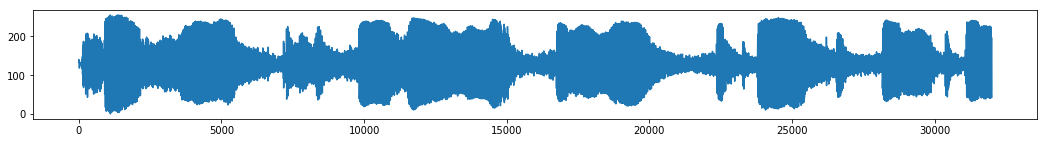

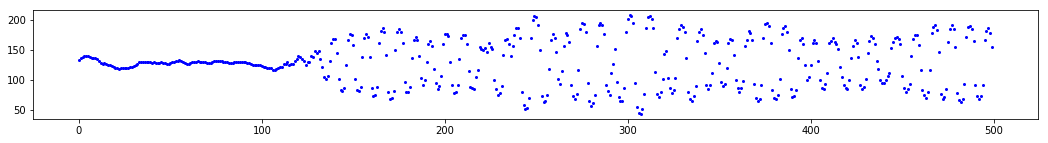

In [9]:
'''
[batch, length] shape을 갖는 wave 데이터를 준비한다.
sample_rate와 quantization에 사용될 mu값을 지정할 수 있다.
'''
def get_data(batch=8, length=8000 * 4, sample_rate=8000, mu=255):
    
    waves = None
    '''
    batch * length 길이의 데이터를 얻을 때 까지 파일에서 로드
    '''
    while(True):
        index = np.random.randint(0, len(data_files))
        wave, _ = librosa.core.load(data_files[index], sr=sample_rate)
        
        # normalization
        wave /= max(wave)
        
        if waves is None:
            waves = wave
        else:
            waves = np.concatenate([waves, wave], axis=0)
            
        if len(waves) > batch * length:
            break

    '''
    [batch, length] shape으로 다듬기
    '''
    waves = waves[:batch * length]
    waves = np.reshape(waves, [batch, length])
    
    '''
    mu-law encoding
    '''
    def mu_law(x, mu=255):
        # reference : https://en.wikipedia.org/wiki/Μ-law_algorithm
        return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)
    
    waves_mu = mu_law(waves)    
    
    '''
    8-bit Quantization
    '''
    # max_value를 곱함
    quantized_8_wav = waves_mu * 128
    # integer로 반올림
    quantized_8_wav = np.round(quantized_8_wav).astype(int)
    # 범위 설정
    quantized_8_wav = np.clip(quantized_8_wav, -128, 127)
    quantized_8_wav += 128

    return quantized_8_wav

'''
preprocessing한 데이터 보기
'''
data = get_data()
print(data.shape)

plt.figure(figsize=[18, 2])
plt.plot(data[0])
plt.show()

plt.figure(figsize=[18, 2])
plt.plot(data[0, :500], 'bo', markersize=2)
plt.show()


## Training Loop

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

while(True):
    for _ in range(100):
        data = get_data(batch=4, length=SampleRate)
        print('data shape :', data.shape)
        _, _loss = sess.run([train_step, loss], feed_dict={X: data})
        print('loss :', _loss)
            
    clear_output()
    

## Sampling


(1, 9021)


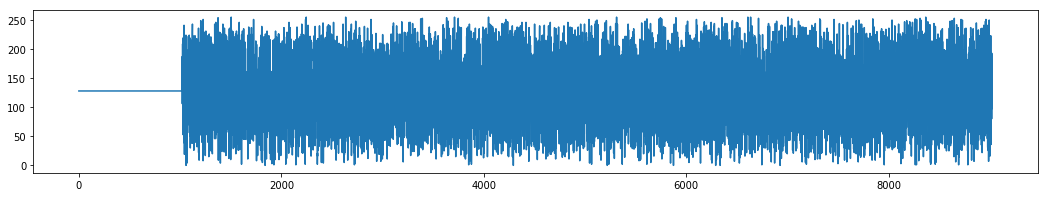

In [11]:
_data = _sample = np.ones([1, ReceptiveField]) * Channels / 2

for _ in tqdm(range(SampleRate)):
    _sample = sess.run(sample, feed_dict={X: _data[:, -ReceptiveField:]})
    _data = np.concatenate([_data, _sample], axis=1)
print(_data.shape)

plt.figure(figsize=[18, 3])
plt.plot(_data[0])
plt.show()